In [54]:
import cv2
import numpy as np

In [43]:
import matplotlib.pyplot as plt
import chainercv
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainer.datasets import TransformDataset
import os.path
from os import path
import glob
import torch

## Create Dataset

In [64]:
import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, split):
        super(DataLoaderSegmentation, self).__init__()
        
        if split not in ['train', 'val']:
            raise ValueError('please pick split from \'train\', \'test\', or \'val\'')
       
        dir_path = dir_path = os.getcwd()
        folder_path = os.path.join(dir_path, 'data', 'tas500v1.1', 'tas500v1.1')
        self.img_files = glob.glob(os.path.join(folder_path, split, '*.png'))
        self.segment_files = []
        for img_path in self.img_files:
            self.segment_files.append(os.path.join(folder_path, split+'_labels_ids', os.path.basename(img_path)))
            
    def __getitem__(self, index):
        img_path = self.img_files[index]
        seg_path = self.segment_files[index]
        data = cv2.imread(img_path, 0)
        seg = cv2.imread(seg_path, 0)
        return torch.from_numpy(data).float(), torch.from_numpy(seg).float()

    def __len__(self):
        return len(self.img_files)

In [65]:
train_data = DataLoaderSegmentation('train')

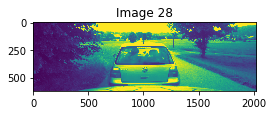

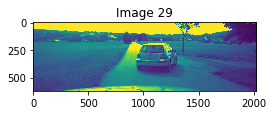

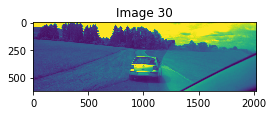

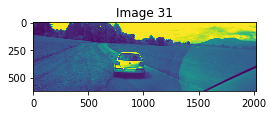

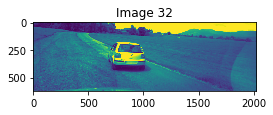

In [80]:
def find_forest_and_car_images():
    forest_label = 5
    car_label = 14
    count = 0
    max_count = 5
    for i in range(len(train_data)):
        tmp_count = np.unique(train_data[i][1], return_counts=True)
        if car_label in tmp_count[0]:
            if count == max_count:
                break
            else:
                img, label = train_data[i]
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)
                plt.title('Image ' + str(i))
                ax.imshow(np.rollaxis(img.numpy().astype(int), 0, 0))
                count += 1

find_forest_and_car_images()